In [2]:
# Author Emmanuel Sedicol
import cv2
import import_ipynb
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# notebook imports
import POSITION_EXTRACTION as pex
import SHOT_CLASSIFICATION as scn

from IPython.display import clear_output
from imutils.video import VideoStream
from imutils.video import FPS
from skimage import measure
from YOLO import yolo

DEBUG = False

## Predict Object:
> - the following function takes in a frame/ image as its input
> - it peforms basic image processing to prepare the image before being classified by the Neural Network

In [3]:
# transform input frame to the corect structure before being classified my the model
def predict_object(frame):
    model = tf.keras.models.load_model("MODEL")
    CATEGORIES = ['basketball', 'hoop']
    
    img = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (80,80))
    img = img.reshape(-1, 80, 80, 1)
    
    # predict image
    prediction = model.predict([img])
    prediction_label = CATEGORIES[int(prediction[0][0])]
    return(prediction_label)

# Ball detection using Opencv
- uses hsv color range to create a mask
- classify detected objects by using the function predict_object() to prepare input frame to the CNN

In [4]:
def opencv_ball_detection(frame, bol):
    detected_object = frame.copy()
    
    # frame filtering and image processing
    blur = cv2.GaussianBlur(frame, (15, 15),0)
    erode = cv2.erode(blur, None, iterations=2)
    dilate = cv2.dilate(erode, None, iterations=2)
    hsv = cv2.cvtColor(dilate, cv2.COLOR_BGR2HSV)
    
    # create mask using lower and upper orange range
    mask = cv2.inRange(hsv, (1, 80, 110), (8,200,175))

    # find contours in the mask and initialize the current
    cnts = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    if  len(cnts) > 0:   
        
        # get maximum contour based on its area value
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        
        # check if the radius meets size criteria
        if radius > 5 and radius < 20 :
            
            # Retrive the frame of detected ball
            detected_object = detected_object[int(y - 20):int(y + 20),int(x - 20):int(x + 20)] 

            if bol == True:
                # if detected object is classifies as a basketball
                if predict_object(detected_object) == "basketball" :
                    # Draw the circle and centroid on the frame,
                    cv2.circle(frame, (int(x), int(y)), int(radius),(0, 255, 255), 2)
                    cv2.circle(frame, (int(x), int(y)), 1, (0, 0, 255), 2)

                    # Draw rectangle around the minimum enclosed circle and dipslay label of detected object
                    cv2.rectangle(frame, (int(x - 20), int(y - 20)), (int(x + 20), int(y + 20)), (255,0,0), 2)
                    cv2.putText(frame, "BASKETBALL", (int(x - 30), int(y - 25)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1 )
            else:
                # if detected object is classifies as a basketball
                if predict_object(detected_object) != "basketball" :
                    # Draw the circle and centroid on the frame,
                    cv2.circle(frame, (int(x), int(y)), int(radius),(0, 255, 255), 2)
                    cv2.circle(frame, (int(x), int(y)), 1, (0, 0, 255), 2)

                    # Draw rectangle around the minimum enclosed circle and dipslay label of detected object
                    cv2.rectangle(frame, (int(x - 20), int(y - 20)), (int(x + 20), int(y + 20)), (255,0,0), 2)
                    cv2.putText(frame, "BASKETBALL", (int(x - 30), int(y - 25)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1 )
            
    return x, y, frame

### Variables for main_app parameters

In [9]:
path = "VIDEOS/MAIN_TEST_SHORT.mov"

court_image = cv2.imread('/Users/esedicol/Desktop/BasketballShotDetectection/images/court/court_invert.png')
court_image  = cv2.resize(court_image, (600,400))

pts_3D = np.array([(0,235), (70, 236), (230, 235), (370, 232), (530, 230), (600, 227), (300, 360), (200, 315), (405, 310)])
pts_2D = np.array([(0, 0), (63, 0),(226, 0), (370, 0), (535, 0), (600, 0), (300, 216), (226, 160), (370, 160) ])

# Main Function
#### in this section we combine all the smaller functions to perform all the aimed fumctionalities:
> - detect player
> - extract player position and map onto a 2D image of court
> - detect basketball using openCV and classify detected object using a CNN Model
> - detect wether the basketball goes in the basket or not

In [10]:
# Main App Function
def main_app(path, court_image, pts_3D, pts_2D):
    shot_xy_coordinates = []
    
    miss_shots = 0
    made_shots = 0
    
    vs = cv2.VideoCapture(path)
    fps = FPS().start()
    
    while True:
        # grab the current frame
        _,frame = vs.read()

        # break out of the application if we have no more frames to read
        if frame is None:
            break
            
        # resize frame so to make its constant size througout
        frame = cv2.resize(frame,(600, 400))
        
        compare_frame = frame[int(80):int(130),int(280):int(325)] 
        compare_frame = cv2.cvtColor(compare_frame, cv2.COLOR_BGR2GRAY)
            
        # detect ball using YOLO
        target_b = "ball"
        frame, detected, _, _, _ = yolo.yolo_detection(target_b, frame)
        
        # detect person using YOLO
        target_p = "person"
        frame, detected, xx, yy, h = yolo.yolo_detection(target_p, frame)
        
        # extract player position and map into 2D court
        warped_frame, mask, court_2D, player_x_coordinate, player_y_coordinate = pex.estimate_position(frame, court_image, pts_3D, pts_2D)
        cv2.putText(frame, 
                    f'(x={round(player_x_coordinate, 2)}, y={round(player_y_coordinate, 2)})', 
                    (int(xx - 60), int(yy + (h/2) + 15)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (25, 255, 25), 1 )

        imc_read = cv2.imread("/Users/esedicol/Desktop/BasketballShotDetectection/images/compare_image.png")
        imc_resize = cv2.resize(imc_read, (600,400))
        imc_cvt = cv2.cvtColor(imc_resize, cv2.COLOR_BGR2GRAY)
        image_to_compare = imc_cvt[int(80):int(130),int(280):int(325)] 
        
        ssim = scn.compare_images(compare_frame, image_to_compare)

        # if ssi scores is over 0.9 (meaning good match)
        if ssim > 0.9:
            made_shots = 1 
            cv2.putText(frame, "!! SCORE !!", (150, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (2, 255, 100), 2 )

        # if YOLO doesnt detect ball use opencv method
        if detected == False:
            x, y, frame = opencv_ball_detection(frame, True)
            shot_xy_coordinates.append((x,y))

        # plot results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
        fig.suptitle('Basketball and Player Detection')
        
        # Column one
        ax1.set_title("Original Frame")
        frame = insert_board(frame, made_shots, miss_shots)
        ax1.imshow(frame) 
        ax1.axis("off")
        
        # Column 2
        ax2.set_title("Player Position")
        court_2D = insert_board(court_2D, made_shots, miss_shots)
        ax2.imshow(court_2D) 
        ax2.set_xlim(0, 600)
        ax2.set_ylim(0,400)
        ax2.axis("off")
        ax2.invert_yaxis()
        
        clear_output(wait=True)
        plt.show()

    fps.stop()
    vs.release()
    print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

In [11]:
def insert_board(frame, make, miss):
    # import the score board  image
    score_board = cv2.imread('images/score_board.png')
    score_board = cv2.resize(score_board, (150, 100))
    
    x_offset = int(450)
    y_offset = int(300)
    
    # replace frame roi with the score_board
    frame[ y_offset:y_offset+score_board.shape[0], x_offset:x_offset+score_board.shape[1]] = score_board
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # MAKE SLOT
    cv2.putText(frame, "MAKE", (470, 310), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1 )
    cv2.putText(frame, str(make), (470, 375), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 2 )
    
    # MISS SLOT
    cv2.putText(frame, "MISS", (550, 310), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1 )
    cv2.putText(frame, str(miss), (550, 375), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 2)
    
    return frame

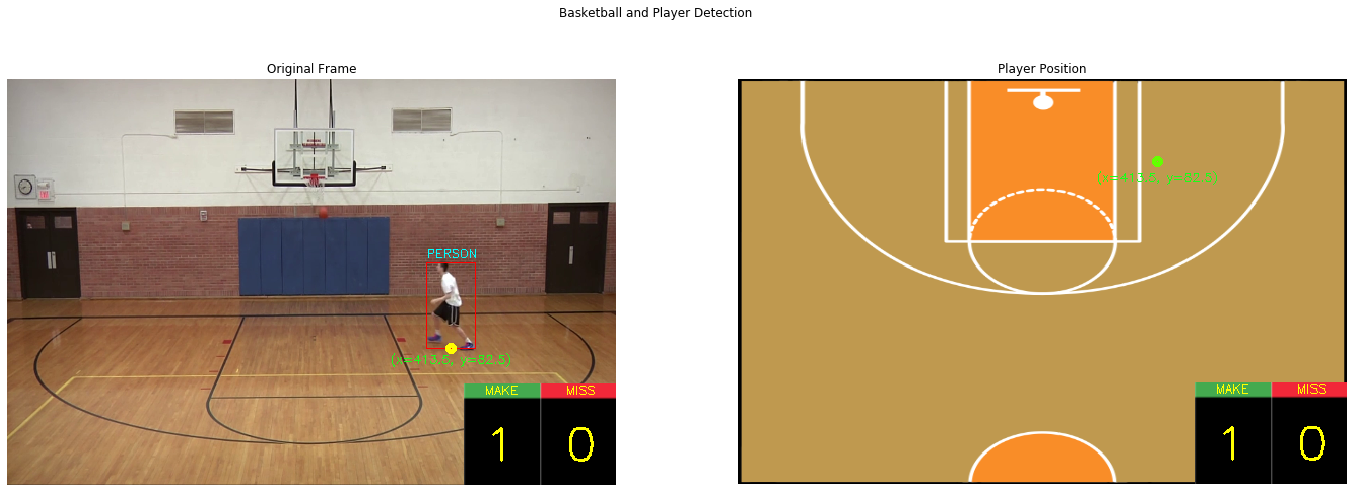

[INFO] elasped time: 63.10
[INFO] approx. FPS: 0.00


In [12]:
main_app(path, court_image, pts_3D, pts_2D)